In [1]:
import numpy as np
import tensorflow as tf
from keras import layers
import keras

In [3]:
inputs = keras.Input(shape=(784,))
# img_inputs = keras.Input(shape=(32,32,3))
dense = layers.Dense(64,activation='relu')
x = dense(inputs)
x = layers.Dense(64,activation='relu')(x)
outputs = layers.Dense(10)(x)

In [4]:
model = keras.Model(inputs=inputs, outputs=outputs, name='mnist_model')
model.summary()

Model: "mnist_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense (Dense)               (None, 64)                50240     
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 10)                650       
                                                                 
Total params: 55,050
Trainable params: 55,050
Non-trainable params: 0
_________________________________________________________________


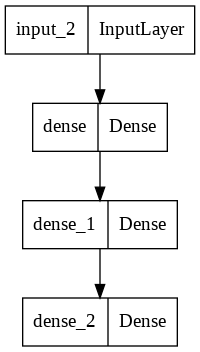

In [5]:
# 모델을 그래프로 표현
keras.utils.plot_model(model,'my_first_model.png')

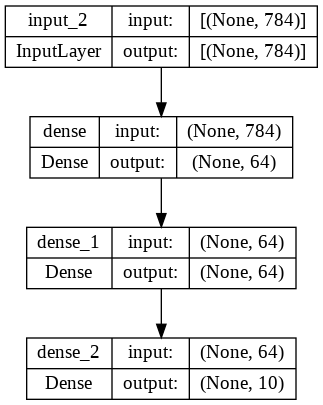

In [6]:
# 선택적으로 플롯 된 그래프에 각 레이어의 입력 및 출력 모양을 표시
keras.utils.plot_model(model, "my_first_model_with_shape_info.png", show_shapes=True)

### 다중 입력 및 출력 모델

사례 : 순위별로 사용자 지정 발급 티켓 순위를 매기로 올바른 부서로 라우팅하는 시스템을 구축하는 경우 모델에는 세가지 입력이 발생

- 티켓의 제목(텍스트 입력)
- 티켓의 본문(텍스틀 입력)
- 사용자가 추가한 모든 태그(범주 입력)

이 모델에는 두가지 출력
- 0과 1사이의 우선 순위 점수(시그모이드 출력)
- 티켓을 처리해야 하는 부서(소프트 맥스 출력)

In [16]:
num_tags = 12 # unique issue tags
num_words = 10000 # size of vocabulary
num_departments = 4 # number of departments for predictions

title_input = keras.Input(shape=(None,), name='title')
body_input = keras.Input(shape=(None,), name= 'body')
tags_input = keras.Input(shape=(num_tags,), name= 'tags')

title_features  = layers.Embedding(num_words,64)(title_input)
body_features = layers.Embedding(num_words,64)(body_input)

title_features = layers.LSTM(128)(title_features)
body_features = layers.LSTM(32)(body_features)

x = layers.concatenate([title_features, body_features, tags_input])

priority_pred = layers.Dense(1, name='priority')(x)
department_pred = layers.Dense(num_departments,name='department')(x)

model = keras.Model(
    inputs = [title_input,body_input,tags_input],
    outputs = [priority_pred, department_pred],
)


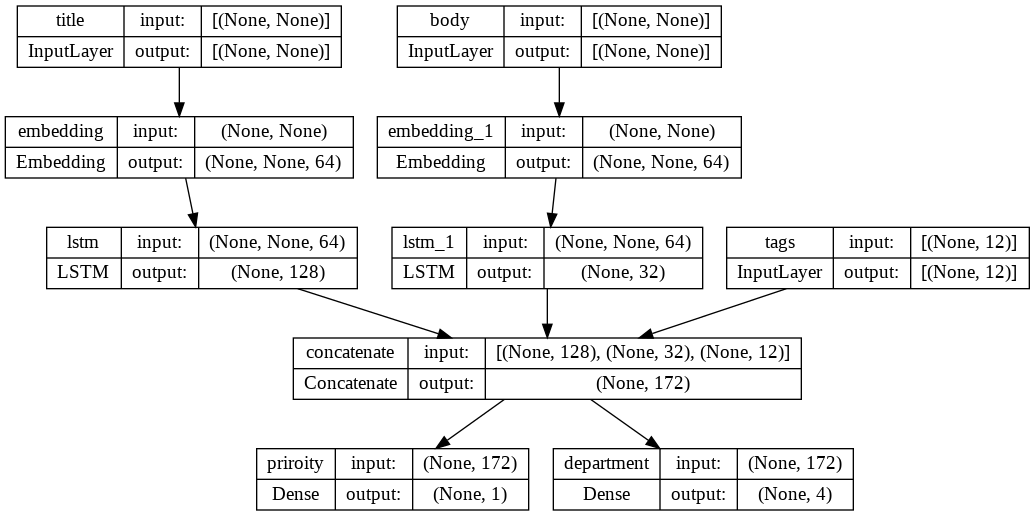

In [9]:
keras.utils.plot_model(model,"multi_input_and_output_model.png", show_shapes=True)

In [14]:
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss = [
        keras.losses.BinaryCrossentropy(from_logits=True),
        keras.losses.CategoricalCrossentropy(from_logits=True),
    ],
    loss_weights=[1.0,0.2],
)

In [17]:
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss = [
        keras.losses.BinaryCrossentropy(from_logits=True),
        keras.losses.CategoricalCrossentropy(from_logits=True),
    ],
    loss_weights={'priority':1.0, 'department':0.2},
)

In [18]:
title_data = np.random.randint(num_words, size=(1280,10))
body_data = np.random.randint(num_words, size=(1280,100))
tags_data = np.random.randint(2,size=(1280,num_tags)).astype('float32')

priority_targets = np.random.random(size=(1280,1))
dept_targets = np.random.randint(2,size=(1280,num_departments))

model.fit(
    {'title': title_data, 'body':body_data, 'tags':tags_data},
    {'priority':priority_targets, 'department':dept_targets},
    epochs=2,
    batch_size=32,
)

Epoch 1/2
40/40 [==============================] - 8s 10ms/step - loss: 1.2889 - priority_loss: 0.7021 - department_loss: 2.9339
Epoch 2/2
40/40 [==============================] - 0s 9ms/step - loss: 1.2769 - priority_loss: 0.6996 - department_loss: 2.8862


### AutoEncoder

In [20]:
encoder_input = keras.Input(shape=(28,28,1),name='original_img')
x = layers.Conv2D(16,3,activation='relu')(encoder_input)
x = layers.Conv2D(32,3,activation='relu')(x)
x = layers.MaxPooling2D(3)(x)
x = layers.Conv2D(32,3,activation='relu')(x)
x = layers.Conv2D(16,3,activation='relu')(x)
encoder_output = layers.GlobalMaxPooling2D()(x)

encoder = keras.Model(encoder_input, encoder_output, name='encoder')
encoder.summary()

decoder_input = keras.Input(shape=(16,),name='encoded_img')
x = layers.Reshape((4,4,1))(decoder_input)
x = layers.Conv2DTranspose(16,3,activation='relu')(x)
x = layers.Conv2DTranspose(32,3,activation='relu')(x)
x = layers.UpSampling2D(3)(x)
x = layers.Conv2DTranspose(16,3,activation='relu')(x)
decoder_output = layers.Conv2DTranspose(1,3,activation='relu')(x)

decoder = keras.Model(decoder_input, decoder_output,name='decoder')
decoder.summary()

autoencoder_input = keras.Input(shape=(28,28,1), name='img')
encoded_img = encoder(autoencoder_input)
decoded_img = decoder(encoded_img)
autoencoder = keras.Model(autoencoder_input, decoded_img, name='autoencoder')
autoencoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 original_img (InputLayer)   [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 26, 26, 16)        160       
                                                                 
 conv2d_5 (Conv2D)           (None, 24, 24, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 32)         0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 6, 6, 32)          9248      
                                                                 
 conv2d_7 (Conv2D)           (None, 4, 4, 16)          4624      
                                                           